In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

# Simulate Observations with Radio Interferometers

To train deep learning models which are able to reconstruct data obtained by radio interferometers, suitable Monte Carlo datasets are essential. Therefore, it is necessary to understand the data produced by radio interferometer arrays and to use a representation for the simulations that comes close to real measurements.
In the following the basics of radio interferometry are explained to give you a better understanding of the general reconstruction idea. An extensive introduction to the fundamentals of radio interferometry can be found [here](https://ratt-ru.github.io/fundamentals_of_interferometry/).

## Radio Interferometers

Radio interferometers collect information in Fourier space. With the help of the inverse Fourier transformation, these information can be used to reconstruct the intensity distrubition of the observed radio source. In radio interferometry, several single dish telescopes are combined to one interferometer array. With this technique effective telescope diameters of the largest distance between two telescopes, also called baseline, can be achieved. The layout of the Very Long Baseline Array ([VLBA](https://science.nrao.edu/facilities/vlba)) is used for our simulations at the moment. An image of the VLBA can be found below.

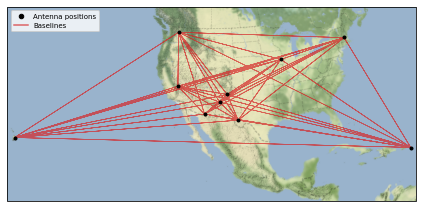

In [2]:
from radionets.simulations.visualize_simulations import create_vlba_overview
create_vlba_overview("./build/simulation_visualization/vlba.pdf")

The VLBA consists of 10 antennas with a disk diameter of 25 meters. The large distances between the individual antennas bring the advantage of very large baselines, which lead to very high resolutions. With baselines over 8000 km it reaches resolutions in the milliarcsecond scales. This offers the possibility to visualize the finest structures of the observed sources. At the same time, this results in the disadvantage of large areas where information cannot be scanned because of large gaps between the telescopes. Therefore, one has to face some problems when analyzing the obtained data with this technique, which is called Very Long Baseline Interferometry ([VLBI](https://en.wikipedia.org/wiki/Very-long-baseline_interferometry)).

## Radio Galaxies

Radio galaxies are a subtype of Active Galactic Nuclei ([AGN](https://en.wikipedia.org/wiki/Active_galactic_nucleus)). They are well known for their emission in the radio frequency regime and common targets of observation campaigns of radio telescopes. Some radio galaxies can be observed as extended sources launching a so-called jet from their core region. With the help of radio interometry these expanding emission regions can be made visible and investigated. A simplified simulation of radio galaxies will be used to explain more about the observation data of radio interferometer arrays.

Nontheless, there are more radio emitting sources which can be found in our universe. Most of them just occur as point sources. Some are appearing as faint extended structures, like supernova remnants or star forming regions just to name some.

Below you can find an image of a simulated radio galaxy. A bright core is visible from which an jet structure emerges.

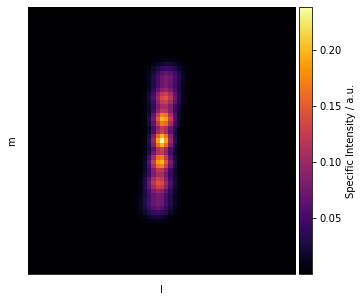

In [3]:
from radionets.simulations.gaussians import gaussian_source, create_grid
from radionets.simulations.visualize_simulations import plot_source, plot_spectrum, ft
###
# adjustments for paper plots
# import h5py
# import numpy as np
# f = h5py.File("../../noise/benchmark_data/source_test8.h5", "r")
# s = np.array(f["sources"])
# sim_source = s[0]
# plt.style.use('./matplotlib_rcs/paper_small.rc')
###
sim_source = gaussian_source(create_grid(63, 1)[0])
plot_source(sim_source, log=False, out_path="./build/simulation_visualization/simulated_source.pdf")

In the simulations, the sources are composed of individual gaussian components, which get blurred with a Gaussian kernel. The number and intensity of the components is varied. Additionally, both single and double sided jets are simulated. The resulting images represent what the source distribution looks like in the sky. As already mentioned, radio interferometers are not able to measure these intensity distributions directly. They collect information in the frequency space, which is connected to the local space by the Fourier transform.

The calculation of the Fourier transform of the example source leads to a two-dimensional arrangement of complex numbers. For better illustration, these complex numbers are decomposed into real and imaginary parts, which in turn are used for the transformation into amplitudes and phases. The resulting distributions are shown below.

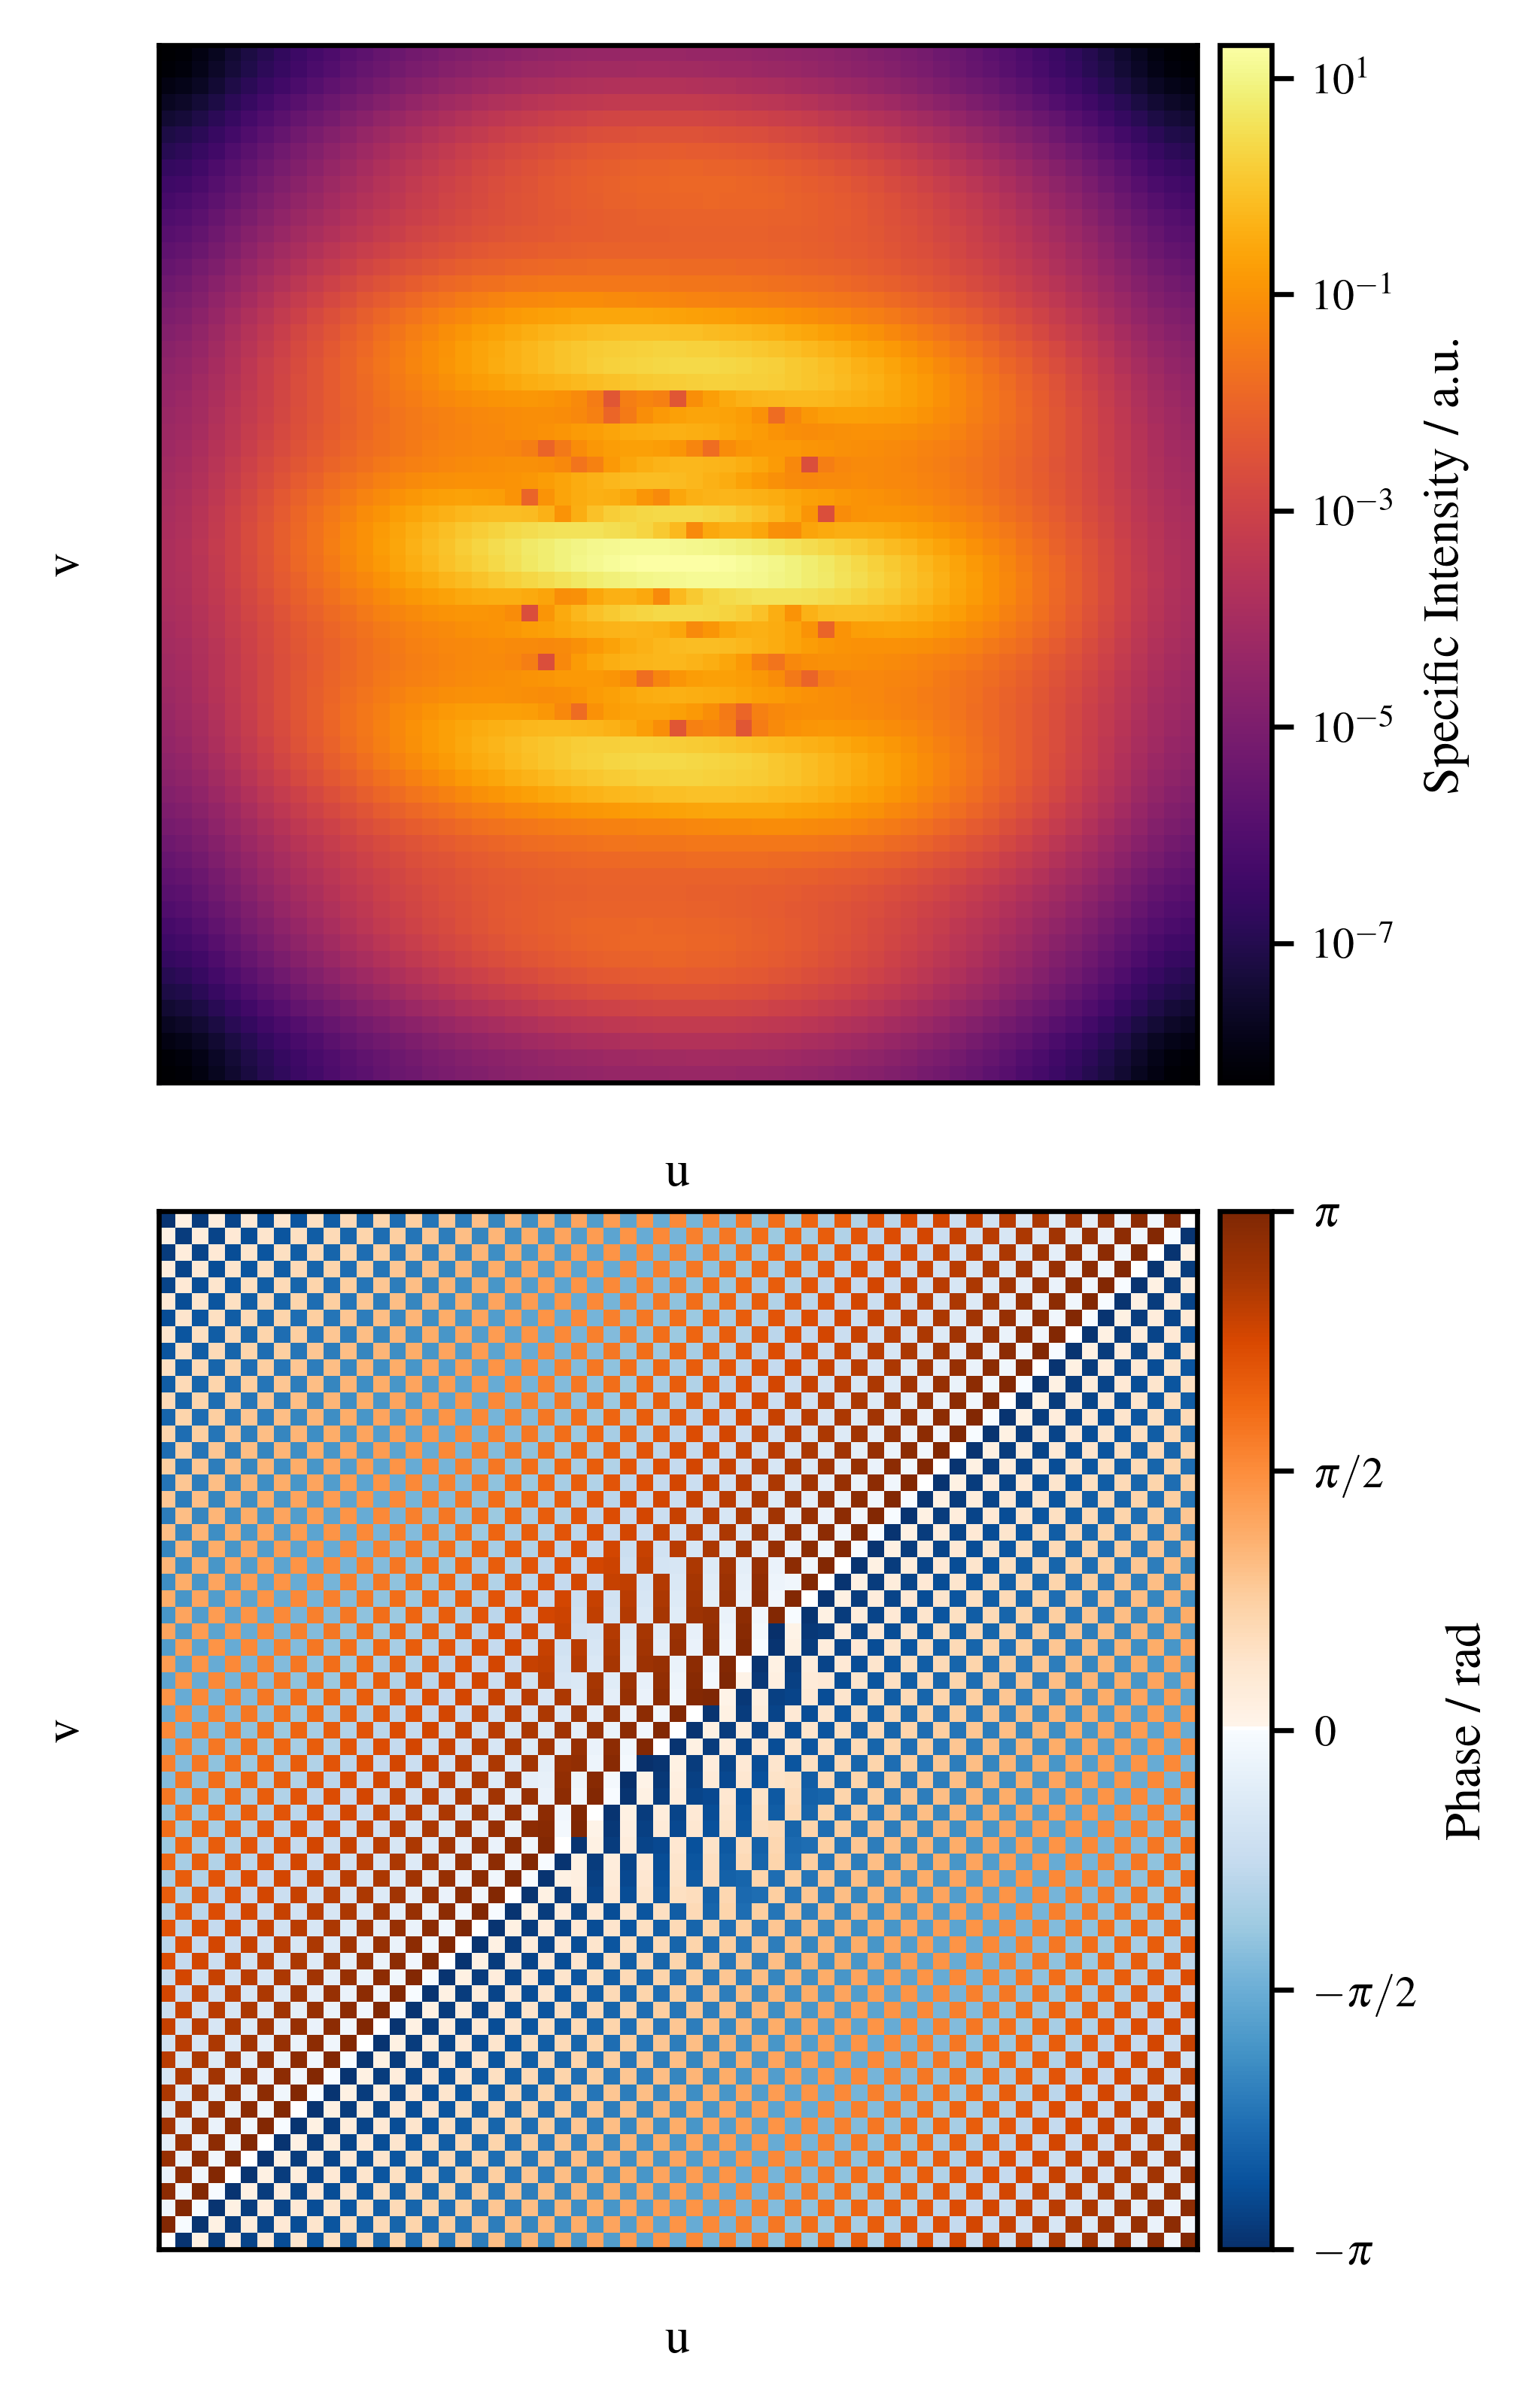

In [4]:
plt.style.use('./matplotlib_rcs/paper_long.rc')
plot_spectrum(ft(sim_source), out_path="./build/simulation_visualization/frequency_distribution.pdf")

This gives us an overview how the complete Fourier spectrum of a simulated radio galaxy can look like. Due to the limited number of antennas, radio interferometers are never able to measure the whole frequency spectrum. We only get a sampled version which we have to use for the reconstruction of the source.

The next section explains the sampling process and its impact on the observed data.

## Sampling

The goal is to achieve simulations that are closely related to real observations. Therefore, the antenna configuration of VLBA is used to sample the Fourier spectra and mimic an observation with this radio interferoemter. The 10 individual antennas of the VLBA make it possibile to sample 90 data points in Fourier space at one time step. This very sparse snapshot coverage is visualized in the figure below.

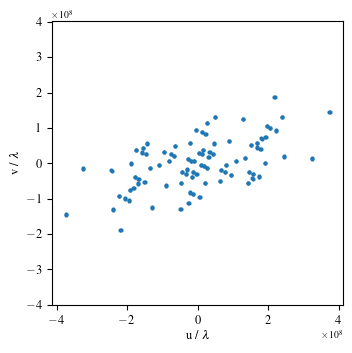

In [5]:
import radionets.simulations.layouts.layouts as layouts
from radionets.simulations.uv_simulations import Antenna, Source, get_uv_coverage
from radionets.simulations.visualize_simulations import plot_vlba_uv

layout = getattr(layouts, "vlba")
ant = Antenna(*layout())
s = Source(-80, 40)
s.propagate(num_steps=1)
u, v, steps = get_uv_coverage(s, ant, iterate=False)
plot_vlba_uv(u, v)

This point marks the beginning of the observation of the source. The figure below shows the 2d projection one gets when looking from source position towards the Earth. This 2d projection is approximately valid as the source lies in astronomical distances away from the observatory.

In [6]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from radionets.simulations.visualize_simulations import plot_baselines, plot_uv_coverage

In [7]:
def plot_antenna_distribution(
    source_lon,
    source_lat,
    source,
    antenna,
    baselines=False,
    end=False,
    lon_start=None,
    lat_start=None,
    out_path=None,
):
    x, y, z = source.to_ecef(val=[source_lon, source_lat])  # only use source ?
    x_enu_ant, y_enu_ant = antenna.to_enu(x, y, z)

    f = plt.figure()
    ax1 = plt.subplot(1, 2, 1, projection=ccrs.Orthographic(source_lon, source_lat))
    ax1.set_global()
    ax1.coastlines()

    ax1.plot(
        x_enu_ant,
        y_enu_ant,
        marker="o",
        markersize=3,
        color="#1f77b4",
        linestyle="none",
        label="Antenna",
    )
    ax1.plot(
        x,
        y,
        marker="*",
        linestyle="none",
        color="#ff7f0e",
        markersize=10,
        transform=ccrs.Geodetic(),
        zorder=10,
        label="Source",
    )

    if baselines:
        plot_baselines(antenna)  # projected baselines
    
    s.propagate()
    s_lon = s.lon_prop
    s_lat = s.lat_prop
    u, v, steps = get_uv_coverage(s, ant, iterate=False)

    ax2 = plt.subplot(1, 2, 2)
    plot_uv_coverage(u, v, ax2)
    ax2.set_ylim(-5e8, 5e8)
    ax2.set_xlim(-5e8, 5e8)
    plt.tick_params(axis="both", labelsize=9)

    ax2.axis("equal")

    if end:
        x_start, y_start, _ = source.to_ecef(val=[lon_start, lat_start])

        ax1.plot(
            np.array([x, x_start]),
            np.array([y, y_start]),
            marker=".",
            linestyle="--",
            color="#d62728",
            linewidth=1,
            transform=ccrs.Geodetic(),
            zorder=10,
            label="Source path",
        )
        ax1.plot(
            x_start,
            y_start,
            marker=".",
            color="green",
            zorder=10,
            label="hi",
            transform=ccrs.Geodetic(),
        )

    
    ax1.legend(
        fontsize=9, markerscale=1, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0
    )
    
    ax2.legend(
        loc=0, fontsize=9, markerscale=1, 
    )
    
    f.subplots_adjust(wspace=.4)
    
    f.tight_layout(pad=0)
    
    if out_path is not None:
        plt.savefig(out_path, dpi=100, bbox_inches="tight", pad_inches=0.05)

In [8]:
# needs to be fixed
# plt.style.use('./matplotlib_rcs/paper_large.rc')
# plot_antenna_distribution(s.lon, s.lat, s, ant, baselines=True,
#                           out_path="./build/simulation_visualization/earth_projection.pdf")

With ongoing observation this projection starts to change as the Earth keeps on rotating. Not only the projected antenna positions start to vary but also the projected baselines between them. This allows it to sample new data points in Fourier space with the same antenna pairs. With ongoing observation the uv-space slowly starts to fill up. This can be seen in the uv coverage at the end of the observation displayed below.

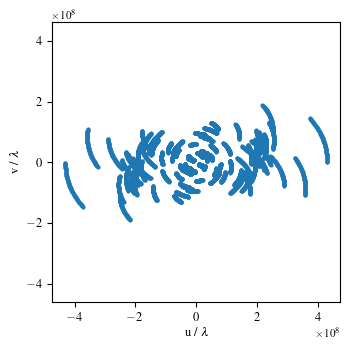

In [9]:
s.propagate()
s_lon = s.lon_prop
s_lat = s.lat_prop
u, v, steps = get_uv_coverage(s, ant, iterate=False)
plt.style.use('./matplotlib_rcs/paper_small.rc')
plot_vlba_uv(u, v, out_path="./build/simulation_visualization/uv_coverage.pdf")

Again we can also have a look at the 2d projection of the interferometer at the end of the observation. It is clearly visible that the projected baselines differ from the ones at the observation start. Furthermore, the path of the source is displayed. One has to keep in mind that the source position is fixed during the observation. The moving pattern only occurs because of the Earth's rotation.

In [10]:
# need to be fixed
# plot_antenna_distribution(s_lon[-1], s_lat[-1], s, ant, baselines=True,
#                           end=True, lon_start=s_lon[0], lat_start=s_lat[0])

The resulting uv-coverage is used to generate a sampling mask, which is applied to the complete spectra of the amp and phase distributions. Sampling mask and sampled spectra are shown below.

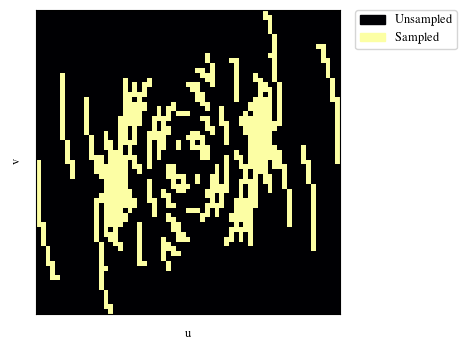

In [11]:
from radionets.simulations.uv_simulations import create_mask
from radionets.simulations.visualize_simulations import plot_mask
mask = create_mask(u, v)
plot_mask(mask)

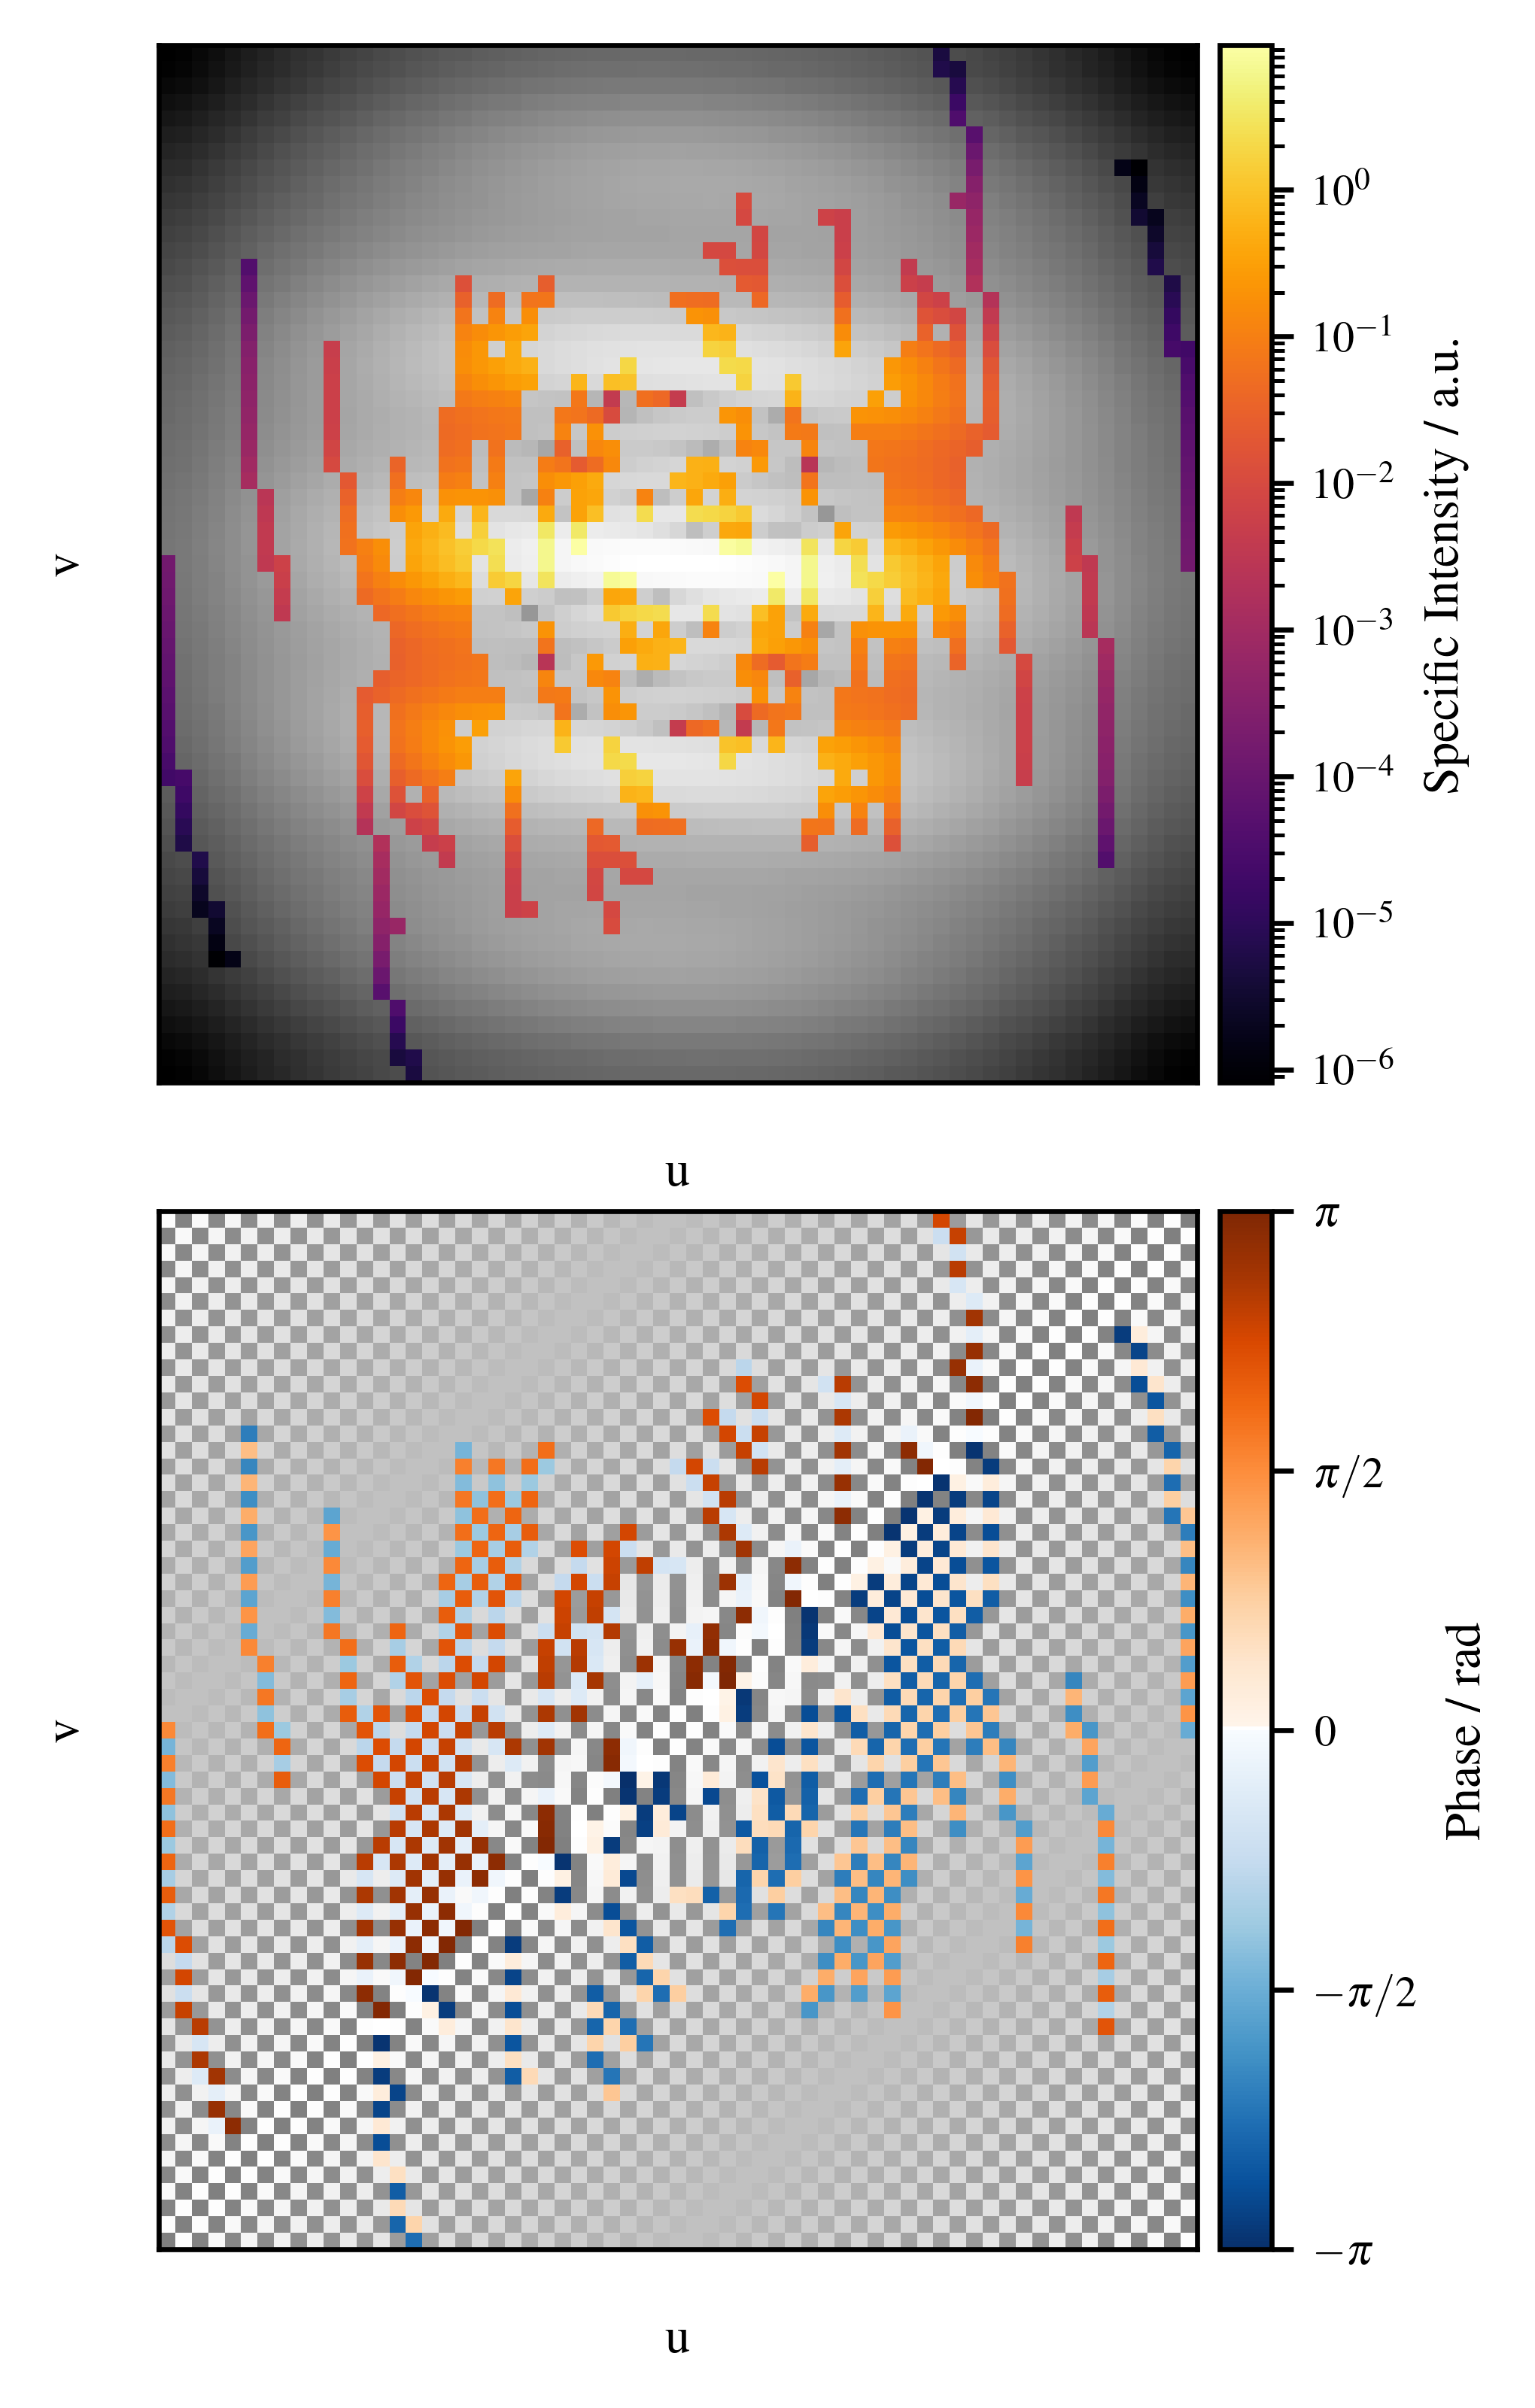

In [12]:
from radionets.simulations.visualize_simulations import apply_mask, plot_spectrum_grey
sampled_freqs = apply_mask(ft(sim_source), mask)
plt.style.use('./matplotlib_rcs/paper_long.rc')
#plt.subplots_adjust(wspace=0.2)
plot_spectrum_grey(ft(sim_source), sampled_freqs, out_path="./build/simulation_visualization/sampled_freqs.pdf")

These incomplete Fourier spectra are compareable to the data one gets from an observation with a radio interferometer. They can be used to calculate a direct reconstruction of the source distribution by applying the inverse Fourier transformation. Nethertheless, the missing information cause in artifacts in the resulting image. For this reason it is also called dirty image. Below you can find the dirty image calculated from the sampled example spectra.

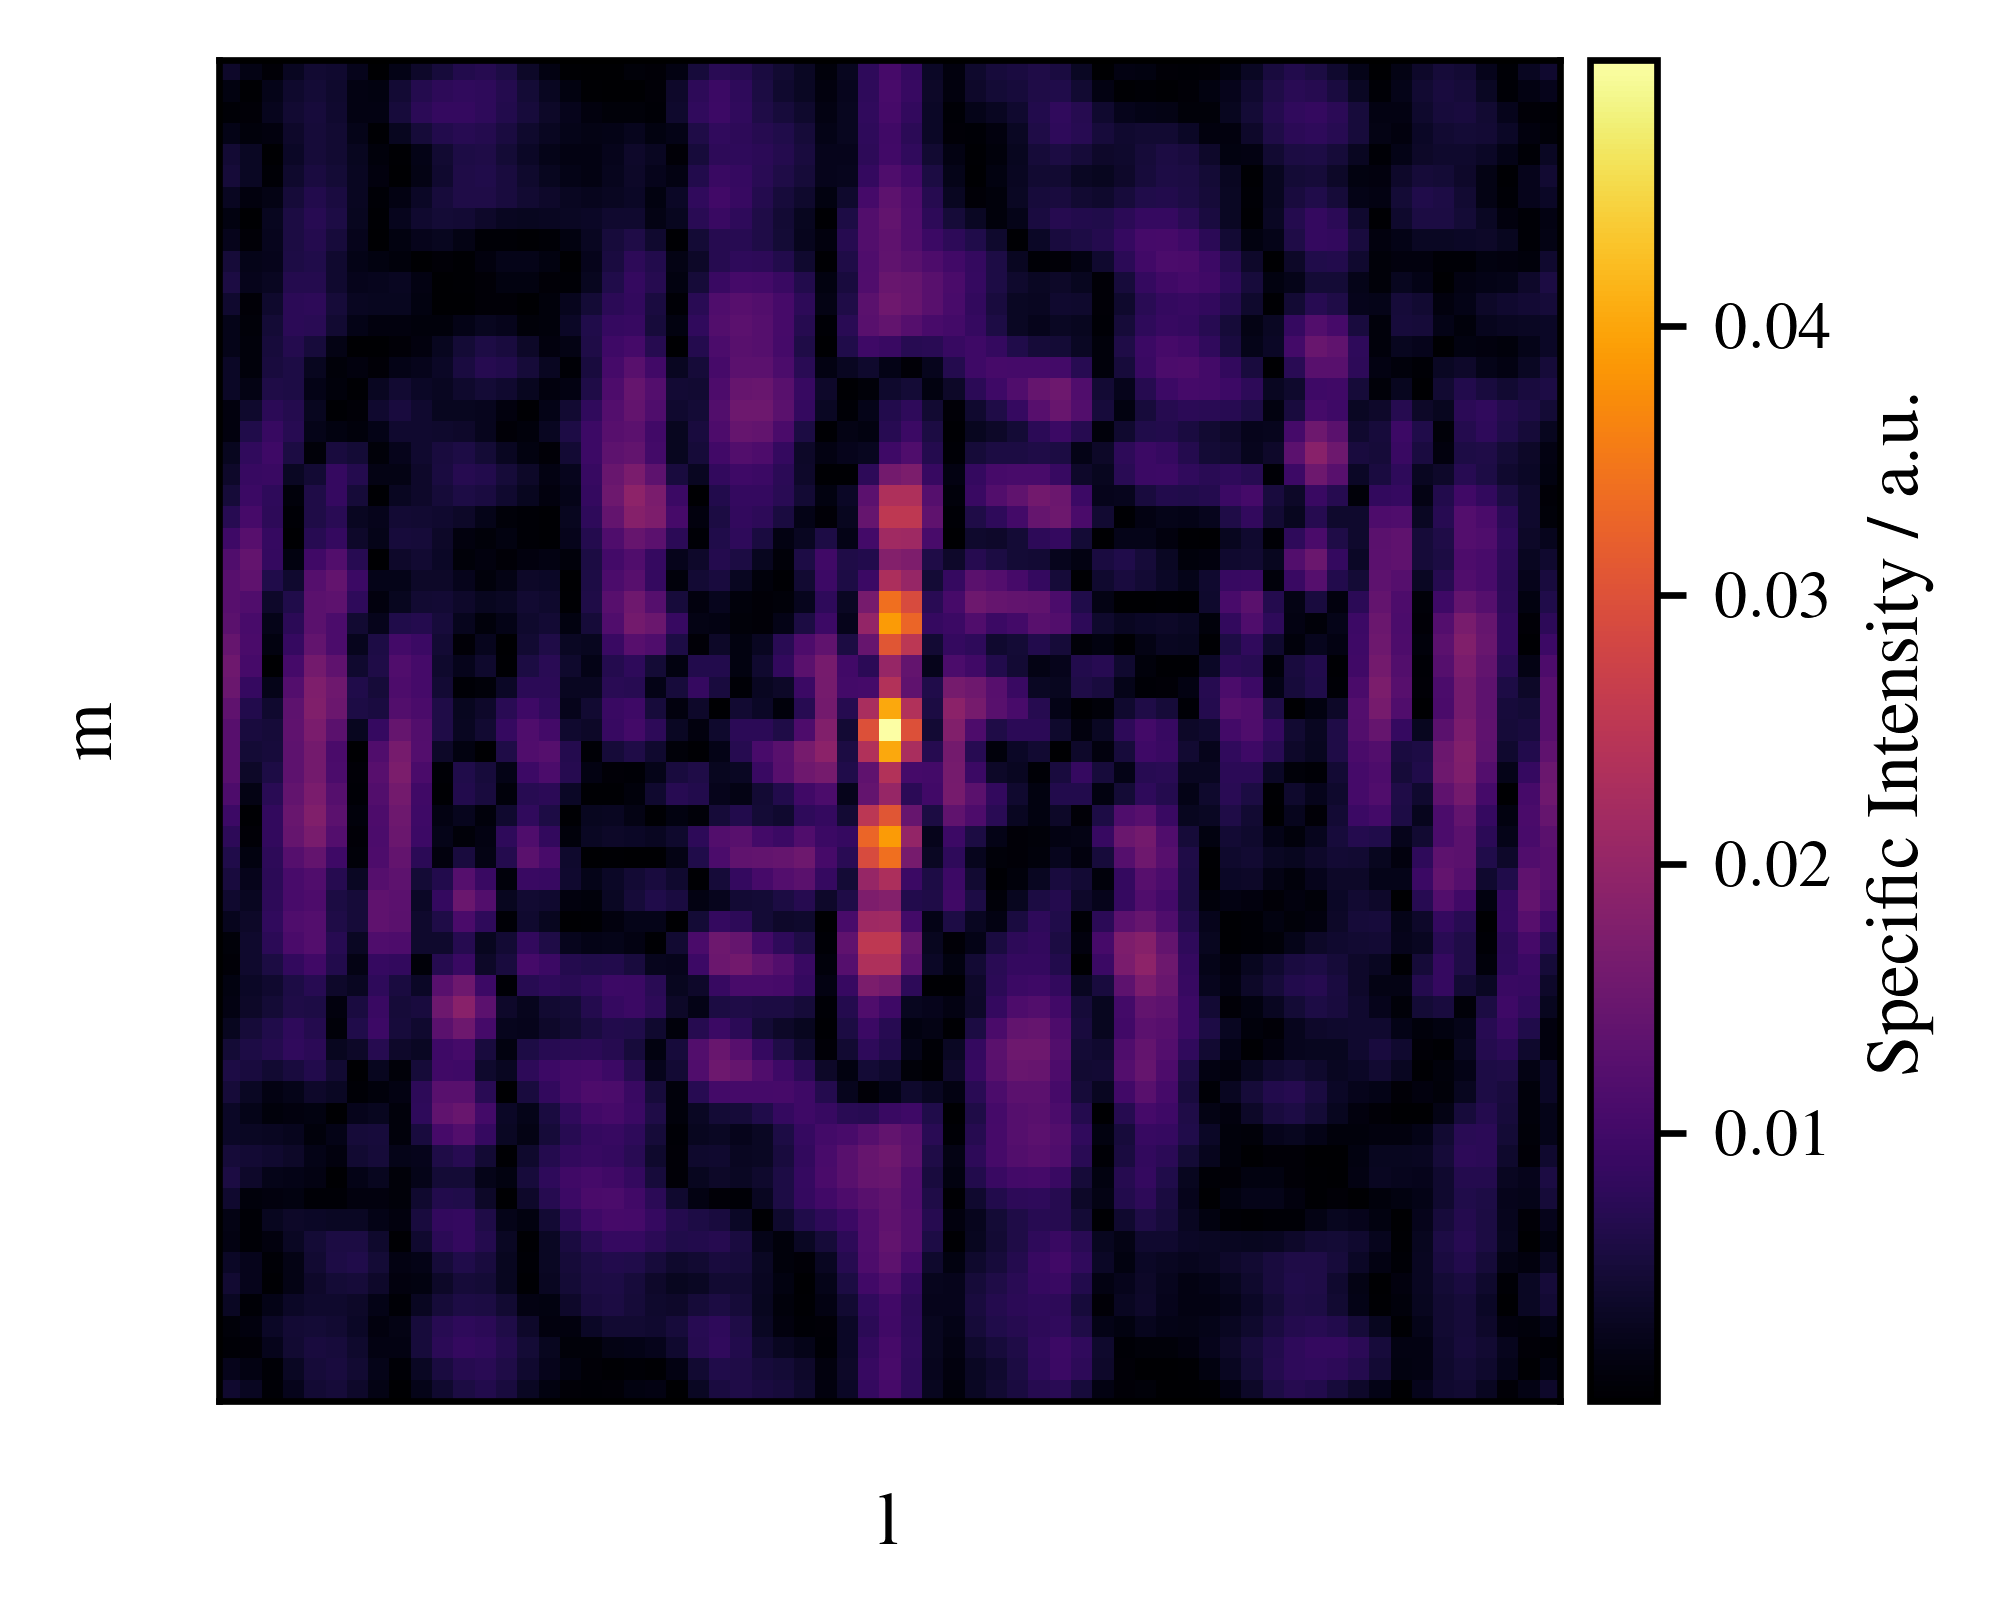

In [13]:
import numpy as np
recons = np.abs(np.fft.ifft2(sampled_freqs))
plt.style.use('./matplotlib_rcs/paper_small.rc')
plot_source(recons, log=False, out_path="./build/simulation_visualization/recons_source.pdf")

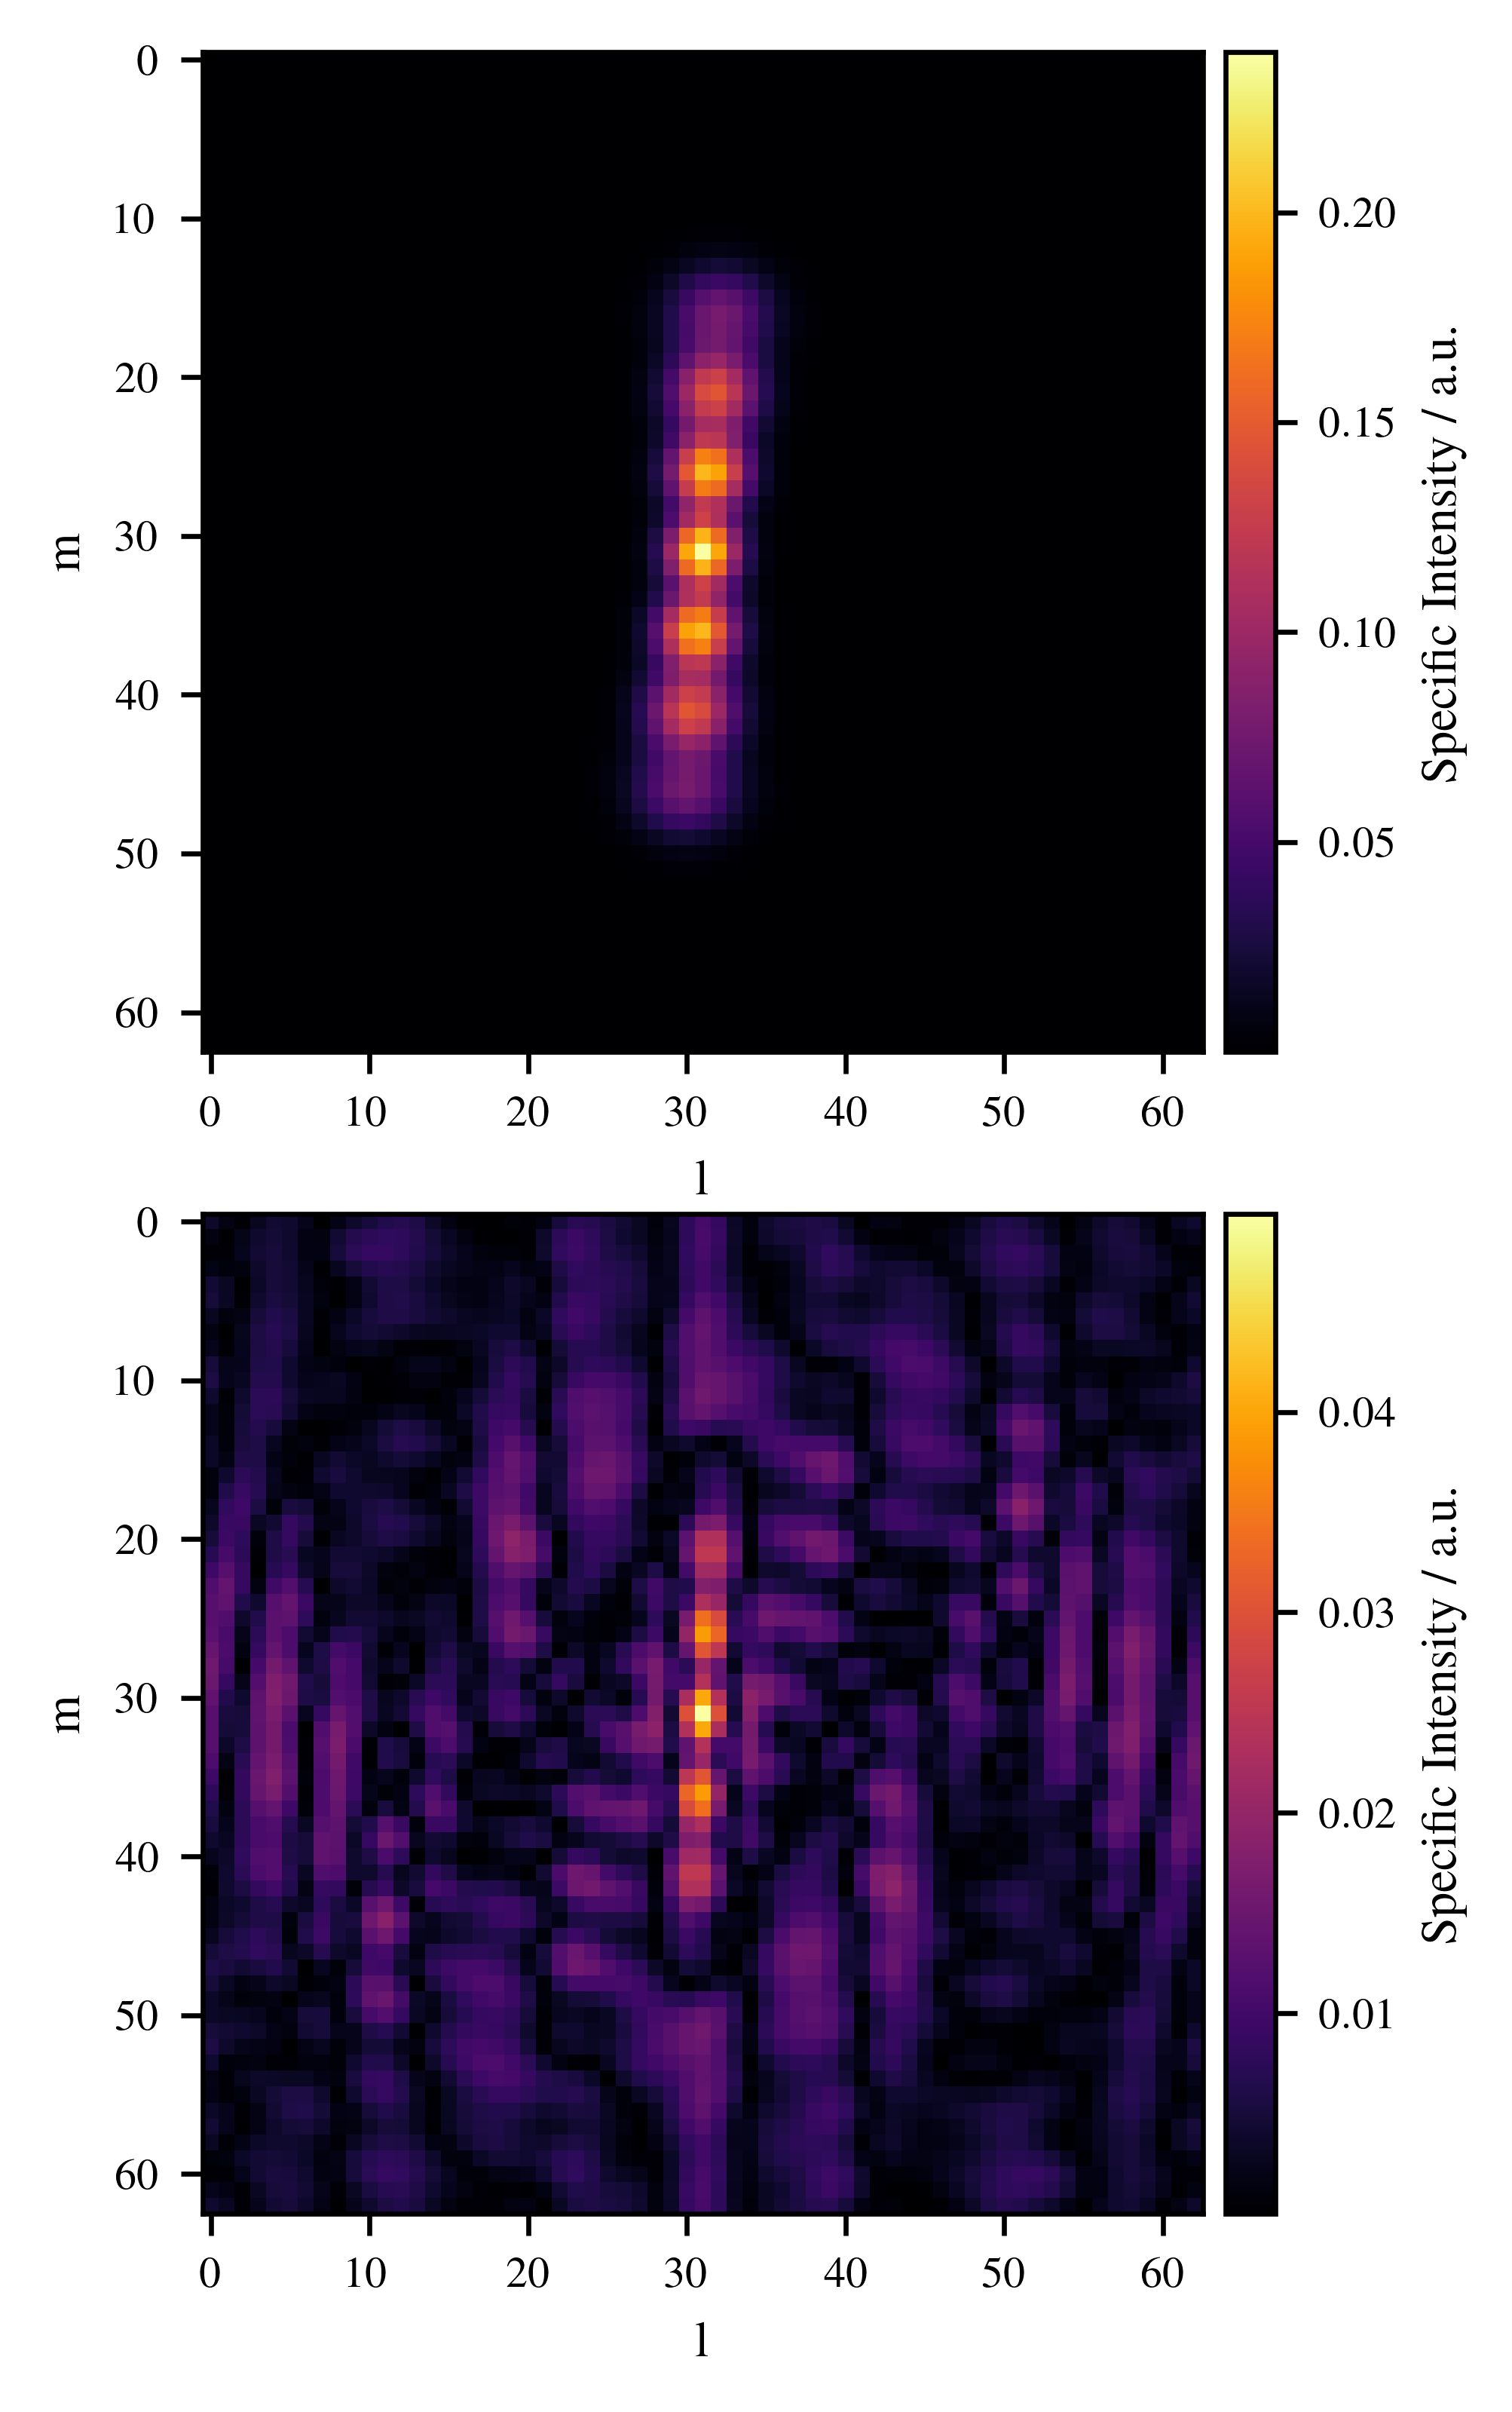

In [14]:
from radionets.simulations.visualize_simulations import plot_comparison
plt.style.use('./matplotlib_rcs/paper_long.rc')
plot_comparison(sim_source, recons, log=False, out_path="./build/simulation_visualization/comparison.pdf")